In [5]:
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    Motifs = list(set(list(R.loc[R['E.tissues']>=1]['motif'])))
    for tis in TISSUES:
        #Review motif policies here
        field= 'eSTR.'+SHORTEN[tis]
        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #
        #frequent_motifs estrs
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            #print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
            #
        Mapdata[tis]=All
    #Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[3] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
    return Mset, O,Mapdata, pdata


SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}

TISSUES = [item for item in list(SHORTEN.keys())]
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'
annotation='/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv'

In [2]:
"""Here we look at STR that fall within genes"""
#open files
feautures = pd.read_csv(feat, sep='\t')
#Only work with STR in gene boundary
regression = pd.read_csv(regr, sep='\t')  ; regr_subset = regression[["chrom","str.start",'str.end','str.id',"gene","E.tissues", "motif" ]]
featgenes = feautures.loc[feautures['feature.type']=='gene']

#Intersect regression and features [within gene boundaries]
regr_subset.to_csv('reg.bed', sep='\t',index=None, header=None)
Genes = featgenes[['chrom','start','stop']]; Genes.to_csv('genes.bed', sep='\t',index=None, header=None)
    #Run bedtools command to intersect them
command = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
returned_value = os.system(command)
    #Call back results
inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
inner.columns=["chrom","str.start",'str.end','str.id',"gene","E.tissues","motif",'chrom_x','gene.start','gene.end']    

#Subselect motifs and position 
data = inner[['chrom','str.start','str.end','gene','str.id']].copy()
data1 = pd.merge(regression, data, on=list(data.columns), how='inner')
print(data.shape, data1.shape)
#Strand maybe?
strands = pd.read_csv(strand, sep='\t', header=None)
strands.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
st_data = pd.merge(data1, strands[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
#annotation
annot = pd.read_csv(annotation, sep=',')
annot['gene']=annot['gene.id']               
annot['chrom'] = annot['gene.chr']
st_data = pd.merge(st_data, annot[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
st_data['Motif']=st_data['For_motif'].where(st_data['gene.strand'] == '+', st_data['Rev_motif']) #Strand annotation


(74817, 5) (74650, 94)


In [6]:
#Non strand annotated
Mset,O,Mapdata,pdata = getfisher(data1,TISSUES)
#clustered heatmap by correlation
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset; print(df1.shape)
Nocount =[x for x in list(df1.columns) if list(df1[x]).count(0)==17 ]
motifs = sorted([x for x in df1.columns if x not in Nocount]) ; len(motifs)

112
(17, 112)


112

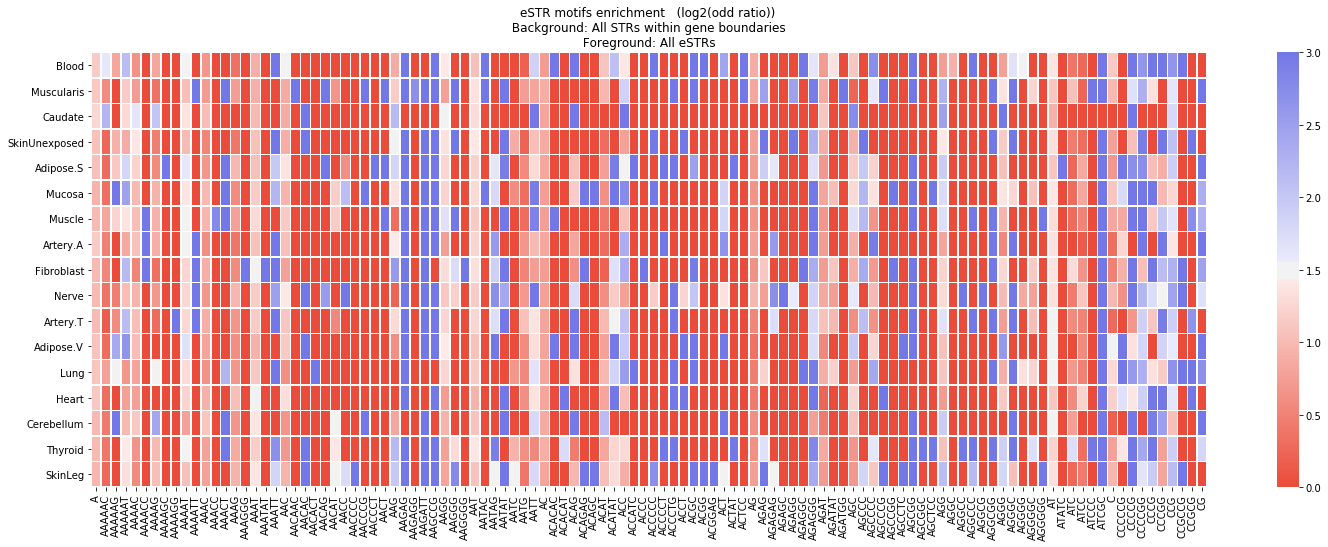

In [8]:
#ODD
#plot Enrichrment by strands
df1 = df1[motifs]
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df1, cmap=cmap, annot_kws={"size": 8},
            vmin=1, vmax=4, linewidths=0.5   );
#ax = g.ax_heatmap
#plt.setp(ax.get_yticklabels(), rotation=0)
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('eSTR motifs enrichment \n Background: All STRs within gene boundaries \n Foreground: All eSTRs ')
plt.show()

In [8]:
df = df1[motifs].copy()
df.loc['Total']= df.sum()
df = df.sort_values(by='Total', axis=1)
#subset_motifs = [x for x in list(df.columns) if df.at['Total',x]>=2]
print(len(Nocount))#df=df[subset_motifs]
df

0


Artery.A         1.729527
Blood                -inf
Muscularis       2.488068
Adipose.V        2.116942
Caudate              -inf
Muscle           1.184965
Thyroid          0.870323
Nerve            0.762464
SkinUnexposed        -inf
Heart                -inf
SkinLeg              -inf
Lung             1.427954
Fibroblast       1.300928
Mucosa           1.211452
Artery.T             -inf
Adipose.S        2.118521
Cerebellum       2.556050
Total                -inf
Name: CG, dtype: float64

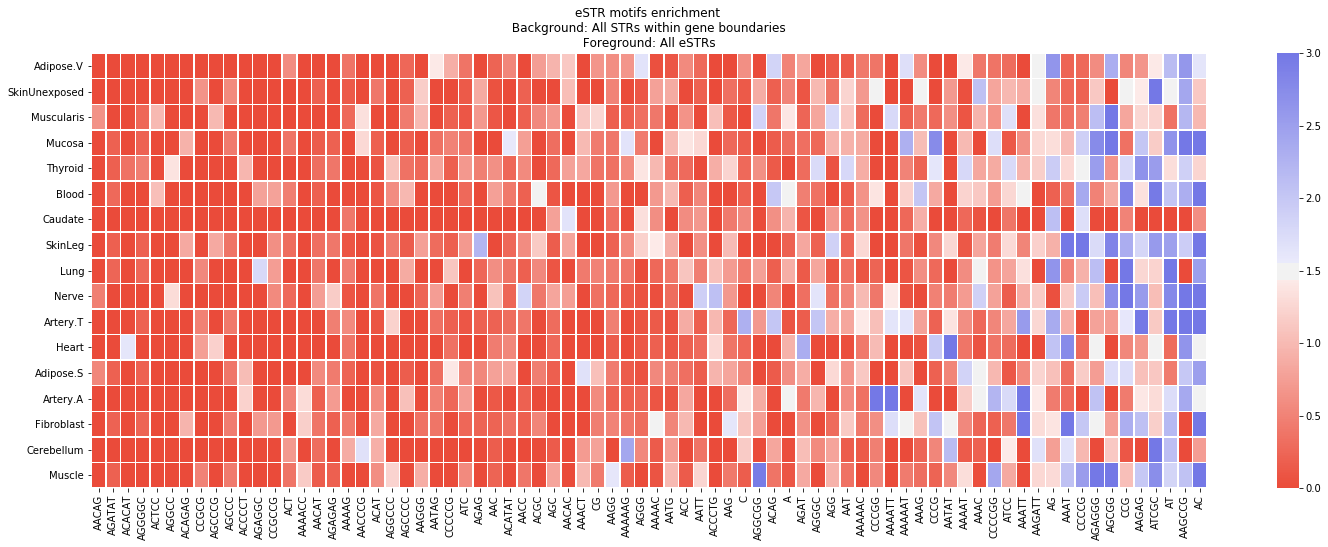

In [45]:
df = df.drop(['Total'])
'''
metric="correlation"
Motifs represented here are only those observed across tissues
'''
#plot Enrichrment by strands
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=3, linewidths=0.5   );
#ax = g.ax_heatmap
#plt.setp(ax.get_yticklabels(), rotation=0)
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('eSTR motifs enrichment \n Background: All STRs within gene boundaries \n Foreground: All eSTRs ')
plt.show()

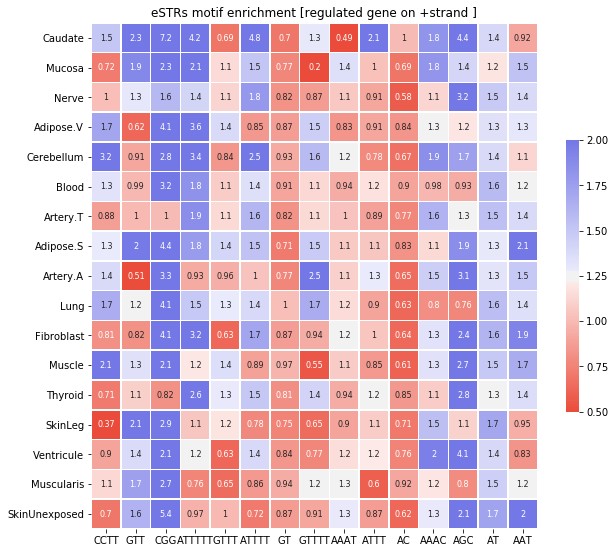

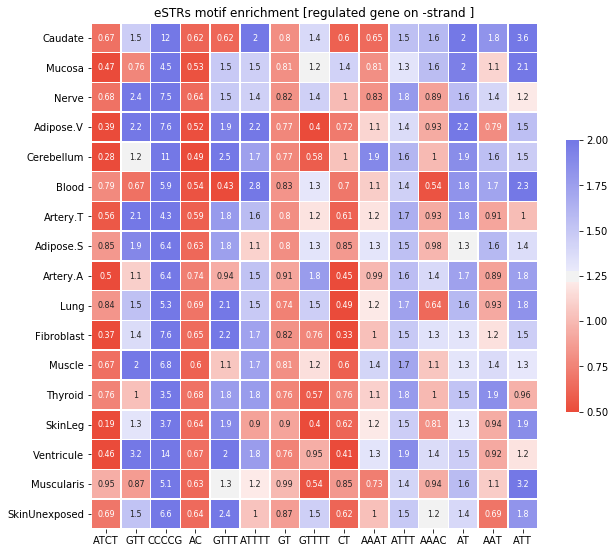

In [7]:
###############################  Strands separately
A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
print(GG.shape)
GG['MOTIF']=GG['motif']
GG['motif']= GG['For_motif'].where(GG['gene.strand'] == '+', GG['Rev_motif'])
print(GG.shape)
print('positive strands')
posGG = GG.loc[GG['gene.strand']=='+']
posMset,Opos,posMapdata,pospdata = getfisher(posGG, TISSUES)
print(posGG.shape, len(posMset))
print('negative strands')
negGG = GG.loc[GG['gene.strand']=='-']
negMset,Oneg,negMapdata,negpdata = getfisher(negGG,TISSUES)
print(negGG.shape,len(negMset))


##Heatmap
#All 
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=Mset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [STR gene ]')
plt.show()
#plot positive strands
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pospdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=posMset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [regulated gene on +strand ]')
plt.show()

#plot negative strands
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(negpdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=negMset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [regulated gene on -strand ]')
plt.show()

In [ ]:
#GG is now data or st_data
#G in now regression         Reg is now regr_subset
#FT is now features           
#Only work with STR in gene boundary
#G = pd.read_csv(regr, sep='\t')  ; X = G[["gene","chrom","str.start","E.tissues"]]
#print(G.shape)
#FTGene = FT.loc[FT['feature.type']=='gene']
#intersect
#Reg = G[['chrom','str.start','str.end','gene','str.id']]; Reg.to_csv('reg.bed', sep='\t',index=None, header=None)
#Genes = FTGene[['chrom','start','stop']]; Genes.to_csv('genes.bed', sep='\t',index=None, header=None)
#print(Reg.shape, Genes.shape)
#cmd = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
#returned_value = os.system(cmd)
#print('Done')
#inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
#inner.columns=['chrom','str.start','str.end','gene','str.id','chrom_x','gene.start','gene.end']
#print(inner.shape)
##data = pd.merge(inner[['chrom','str.start','str.end','gene','str.id']], G, on =['chrom','str.start','str.id','gene','str.end'])
#data.shape   #G=data
#Strands = pd.read_csv(strand, sep='\t', header=None)
#Strands.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
#G = pd.merge(G, S[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
#print(G.shape)
#
#A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
#A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
#GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
#GG['Motif']=GG['For_motif'].where(GG['gene.strand'] == '+', GG['Rev_motif']) #Strand annotation
#print(GG.shape)